# Statistical Parameter Estimation 2024
## Exercise 3

Author: Alex Karonen

Problem 1: 


Consider the SIR model, consider modelling of synthetic data,
and then make parameter estimation for $\beta$ and $\gamma$.
- Get either an analytical solver, or a numerical solver, which outputs
S(t), I(t), R(t).
- Make synthetic test case with noise-perturbed observations, e.g.
$S_{observed}(t) = S_{truth}(t) + \textbf{e} $
where $\textbf{e} ∼ N (0, \sigma^2\textbf{I})$
- Write posterior distribution for $(\beta, \gamma)^T$
.
- Use MCMC to get posterior estimates and uncertainty quantification,
and evaluate MCMC chains.
- Plot predictive intervals.

ODE solution

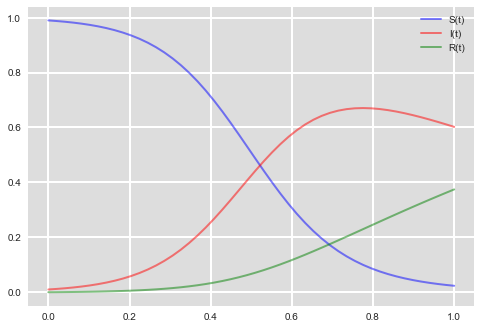

In [1]:
import numpy as np
from scipy.integrate import odeint
import scipy.stats as ss
import scipy.optimize as so
import matplotlib.pyplot as plt
from MCMC import *
import warnings
warnings.filterwarnings("ignore")

# Total population, N.
N = 1

# Initial number of infected and recovered individuals, I0 and R0.
I0, R0 = 0.01, 0

# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - R0

beta, gamma = 10, 1

t = np.linspace(0, 1, 50)


# The SIR model differential equations.
def deriv(y, t, N, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return dSdt, dIdt, dRdt


# Initial conditions vector
y0 = S0, I0, R0
# Integrate the SIR equations over the time grid, t.
sol = odeint(deriv, y0, t, args=(N, beta, gamma))
S, I, R = sol.T

fig = plt.figure(facecolor="w")
ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
ax.plot(t, S, "b", alpha=0.5, lw=2, label="S(t)")
ax.plot(t, I, "r", alpha=0.5, lw=2, label="I(t)")
ax.plot(t, R, "g", alpha=0.5, lw=2, label="R(t)")
ax.grid(which="major", c="w", lw=2, ls="-")
legend = ax.legend()
plt.show()

Synthetic data from ODE-solution

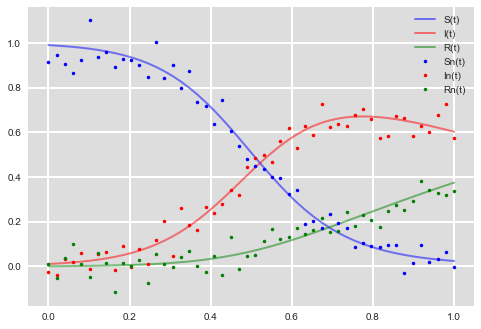

In [2]:

sigma = 0.05
cov = np.eye(3)*sigma**2
mu = np.zeros(3)
e = np.random.multivariate_normal(mu, cov, len(t))

Sn, In, Rn = (sol + e).T


fig = plt.figure(facecolor="w")
ax = fig.add_subplot(111, facecolor="#dddddd", axisbelow=True)
ax.plot(t, S, "b", alpha=0.5, lw=2, label="S(t)")
ax.plot(t, I, "r", alpha=0.5, lw=2, label="I(t)")
ax.plot(t, R, "g", alpha=0.5, lw=2, label="R(t)")
ax.plot(t, Sn, "b.", label="Sn(t)")
ax.plot(t, In, "r." ,label="In(t)")
ax.plot(t, Rn, "g.", label="Rn(t)")
ax.grid(which="major", c="w", lw=2, ls="-")
legend = ax.legend()
plt.show()

Posterior for $(\beta, \gamma)^T$

Let $ \theta = (\beta, \gamma)^T$ and $X(t) = (S(t), I(t) , R(t))^T$.
$$

    p(\theta|X(t)) \propto p(\theta)p(X(t)|\theta)

    = p(\theta) \frac{1}{\sqrt{2\pi|\sigma^2I|}}\exp(-\frac{1}{2}X(t)^T\Sigma^{-1}X(t))
$$

In [3]:

Xn = np.array([Sn, In, Rn])
X = lambda theta: Xn - odeint(deriv, y0, t, args=(N, theta[0], theta[1])).T

def posterior(theta):
    prior = ss.multivariate_normal(mean=np.array([10, 0.5]), cov=np.eye(len(theta))).pdf(theta)
    C = np.linalg.cholesky(np.linalg.inv(cov))
    likelihood = (1 /(np.sqrt((2*np.pi)**len(t)* np.linalg.det(cov))))*np.exp(-1/2*np.linalg.norm(C@X(theta)))
    value = prior * likelihood

    return value


neglogpost = lambda t: -np.log(posterior(t))



x0 = np.array([0,0])



MAP = so.fmin(neglogpost, x0=x0)

print(MAP)

Optimization terminated successfully.
         Current function value: 44.844801
         Iterations: 77
         Function evaluations: 145
[9.96901918 0.97480905]


In [4]:
N = int(1e4)


burn = 0.1
step_size = 1
init_cov = np.eye(len(MAP))
samples, acc = adap_MHMC(posterior, MAP, init_cov, N, 100, step_size, burn)




Accept ratio: 0.3572222222222222


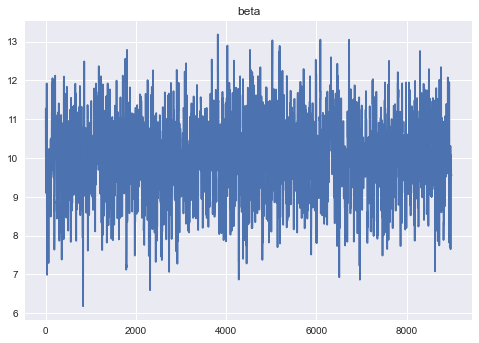

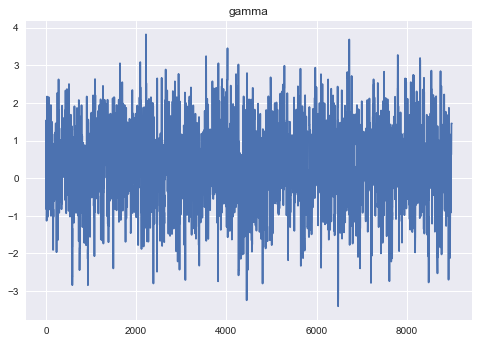

In [5]:
plot_chains(chains=samples, labels=["beta", "gamma"])

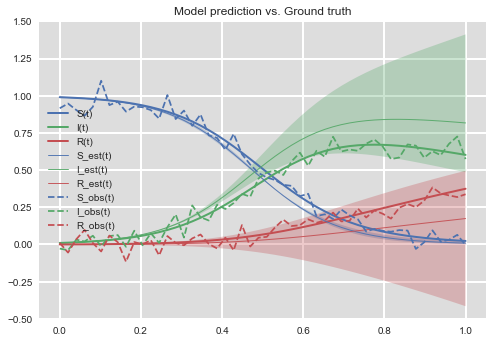

In [6]:
est_beta, est_gamma = np.mean(samples, axis=0)
std_beta, std_gamma = np.std(samples, axis=0)
N0 = 1


sol_n = odeint(deriv, y0, t, args=(N0, est_beta, est_gamma))
sol_upper = odeint(deriv, y0, t, args=(N0, est_beta + std_beta, est_gamma + std_gamma))


sol_lower = odeint(deriv, y0, t, args=(N0, est_beta - std_beta, est_gamma - std_gamma))

labels = [
    "S(t)",
    "I(t)",
    "R(t)",
    "S_est(t)",
    "I_est(t)",
    "R_est(t)",
    "S_obs(t)",
    "I_obs(t)",
    "R_obs(t)",
]


plot_intervals(sol_lower, sol_upper, sol_n, Xn.T, sol, t, labels)

Problem 2: 

Take one realisation of white noise, form posterior distribution,
and obtain variance estimate with MCMC. Make the standard plots.


In [7]:
t = np.linspace(0, 1, 100)

h = t[1] - t[0]

White_noise = lambda sigma: np.random.multivariate_normal(mean=np.zeros(len(t)), cov=sigma**2/h*np.eye(len(t)))


sigmasq = 0.5**2

W_t = White_noise(np.sqrt(sigmasq))
X_t = lambda sigmasq: (W_t - White_noise(np.sqrt(sigmasq)))


def likelihood(sigmasq):
    if sigmasq<0:
        return 0
    SIGMA = sigmasq / h * np.eye(len(t))
    ss = X_t(sigmasq).T @ np.linalg.inv(SIGMA) @ X_t(sigmasq)
    return (
        1
        / (np.sqrt((2 * np.pi) ** len(t) * (sigmasq / h) ** len(t)))
        * np.exp(-1 / 2 * ss)
    )


priori = lambda ssq: ss.uniform(loc=sigmasq-0.05, scale=0.1).pdf(ssq)

def posteriori(sigmasq):
    return priori(sigmasq) * likelihood(sigmasq)


neglogpost = lambda s: -np.log(posteriori(s))

MAP = so.fmin(neglogpost, x0=0.22)

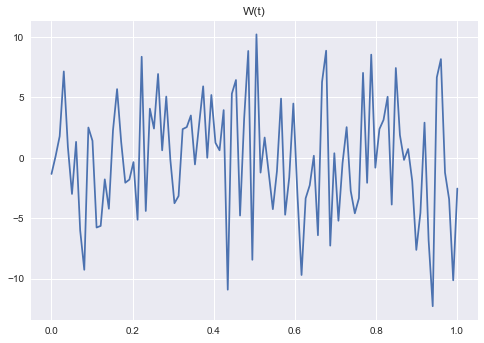

In [8]:

plt.plot(t, W_t)
plt.title("W(t)")
plt.show()


In [9]:
N = int(1e4)


burn = 0.1
step = 0.1
samples, acc = MHMC(posteriori, MAP, N, step, burn)


Accept ratio: 0.0003333333333333333


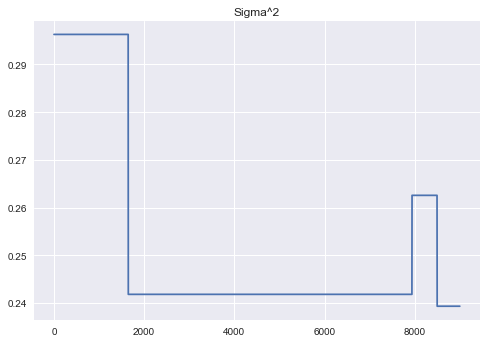

In [10]:
plot_chains(samples, ["Sigma^2"])

Doesn't really work, I don't know what is wrong with this implementation.

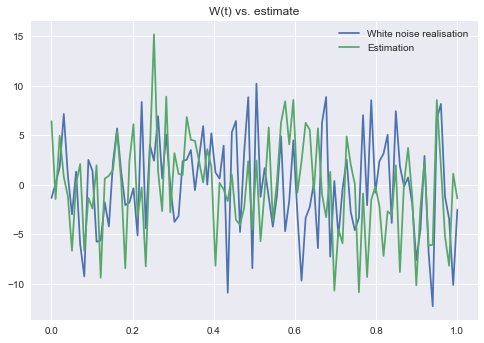

In [11]:
est_sigmasq = np.mean(samples)

est_Wt = White_noise(np.sqrt(est_sigmasq))

plt.plot(t, W_t, label="White noise realisation")
plt.plot(t, est_Wt, label="Estimation")
plt.title("W(t) vs. estimate")
plt.legend()
plt.show()

Problem 3:
1. Given one realisation of the Ornstein-Uhlenbeck process with fixed σ,
use MCMC to obtain CM-estimate of λ. That is,


- Draw one realisation of the OU process.
- Formulate the posterior of λ.
- Use MCMC to estimate λ.
- Plot chains, ACFs, densities and compute ESS and OES.
- Visualise posterior parameter estimates and Monte Carlo errors.

In [12]:

lam = 0.8
sigma = 0.8

t = np.linspace(0, 1, 50)


def OU_process(t, params):
    h = t[1] - t[0]
    lam = params[0]
    L = np.eye(len(t)) + np.eye(len(t), k=-1) * -lam
    inv_L = np.linalg.inv(L)
    sigmap = sigma 

    C = sigmap * inv_L.T @ inv_L
    
    return np.random.multivariate_normal(np.zeros(len(t)), C)


OU_real = OU_process(t, [lam])

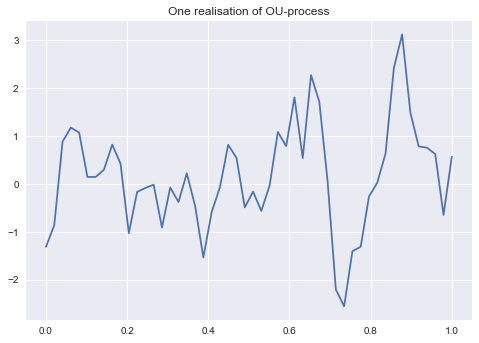

In [13]:
plt.plot(t, OU_real)
plt.title("One realisation of OU-process")
plt.show()

- Use a uniform prior $\lambda \sim Unif(a, b)$, where a < b are suitable
constants.

In [36]:
def likelihood(params):
    L = np.eye(len(t)) + np.eye(len(t), k=-1) * -params[0]
    inv_L = np.linalg.inv(L)
    sigmap = sigma
    C = sigmap**2 * inv_L.T @ inv_L
    X_t = OU_real - OU_process(t, params)
    ss = X_t.T @ np.linalg.inv(C) @ X_t
    value = (
        1 / (np.sqrt((2 * np.pi) ** len(t) * np.linalg.det(C))) * np.exp(-1 / 2 * ss)
    )
    return value


def priori_U(params):
    return ss.uniform(0.7, 0.9).pdf(params)  # U(0,1)


def priori_N(params):
    return ss.norm(0, 0.8**2).pdf(params)  # Norm(0,0.8^2)


def priori_LN(params):
    return priori_N(np.log(params))  # Log(norm(0,0.8^2))


def posteriori_U(params):
    return priori_U(params) * likelihood(params)


def posteriori_N(params):
    return priori_N(params) * likelihood(params)


def posteriori_LN(params):
    return priori_LN(params) * likelihood(params)


neglogpost = lambda p: -np.log(posteriori_U(p))
# find MAP to get a starting point for the MCMC
MAP = so.fmin(neglogpost, x0=0.75, maxiter=1000)
print(f"MAP: {MAP}")

MAP: [0.76874998]


In [37]:
import time
N = int(1e4)

burn = 0.1
step = 0.0001
t0 = time.time()
samples_U, acc = MHMC(posteriori_U, MAP, N, step, burn)
t1 = time.time()
t_Uniform = t1-t0

Accept ratio: 0.00044444444444444447


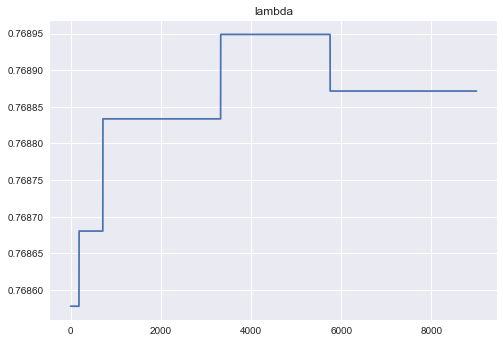

In [38]:
plot_chains(samples_U, ["lambda"])

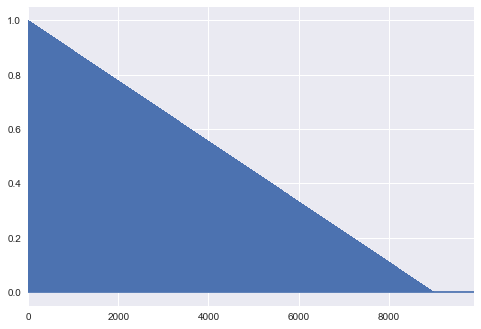

In [39]:
_, U_corr, _, _ = plt.acorr(samples_U.squeeze(), maxlags=None)
plt.xlim([0, None])
plt.show()


def OES_ESS(N, corr, time):
    ESS = N / (1 + 2 * np.sum(corr[N // 2 :]))
    OES = ESS / time
    return ESS, OES


ESS_U, OES_U = OES_ESS(N, U_corr, t_Uniform)

2. In order to see different behaviour of priors, do the same as above, but
with different priors

- Use a Gaussian prior for $\lambda \sim N(0, \sigma^2_{pr})$.
- Use a logarithmic transformation, that is $log(\lambda) \sim N(0, \sigma^2_{pr})$.


Choose the prior parameters in such a way that you can see different
effects of the priors.

In [40]:
neglogpost = lambda p: -np.log(posteriori_N(p))
# find MAP to get a starting point for the MCMC
MAP = so.fmin(neglogpost, x0=0.75, maxiter=1000)
print(f"MAP: {MAP}")

MAP: [0.78807907]


In [41]:
t0 = time.time()
samples_N, acc = MHMC(posteriori_N, MAP, N, step, burn)
t1 = time.time()
t_normal = t1 - t0

Accept ratio: 0.002111111111111111


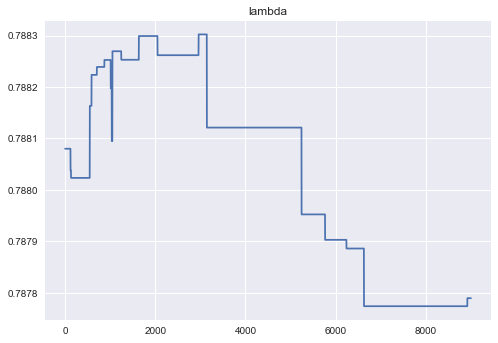

In [42]:
plot_chains(samples_N, ["lambda"])

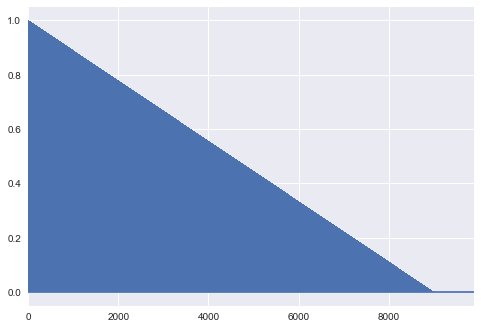

In [43]:
_, N_corr, _, _ = plt.acorr(samples_N.squeeze(), maxlags=None)
plt.xlim([0, None])
plt.show()


ESS_N, OES_N = OES_ESS(N, N_corr, t_normal)

In [44]:
neglogpost = lambda p: -np.log(posteriori_LN(p))
# find MAP to get a starting point for the MCMC
MAP = so.fmin(neglogpost, x0=0.75, maxiter=1000)
print(f"MAP: {MAP}")

MAP: [0.77108917]


In [45]:
t0 = time.time()
samples_LN, acc = MHMC(posteriori_LN, MAP, N, step, burn)
t1 = time.time()
t_Lnormal = t1 - t0

Accept ratio: 0.00011111111111111112


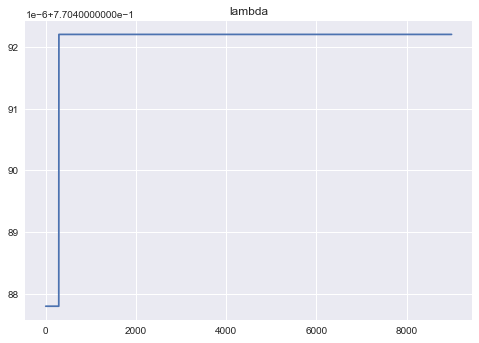

In [46]:
plot_chains(samples_LN, ["lambda"])

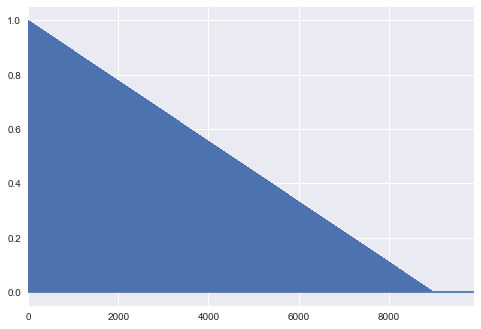

In [47]:
_, LN_corr, _, _ = plt.acorr(samples_LN.squeeze(), maxlags=None)
plt.xlim([0, None])
plt.show()




ESS_LN, OES_LN = OES_ESS(N, LN_corr, t_Lnormal)

Posterior visualizations

In [48]:
est_U = np.mean(samples_U)
est_N = np.mean(samples_N)
est_LN = np.mean(samples_LN)

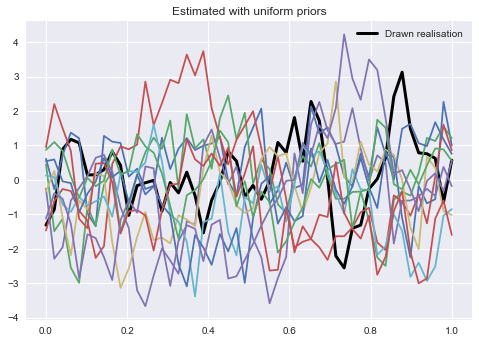

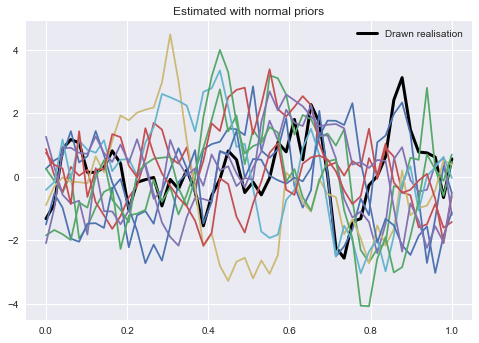

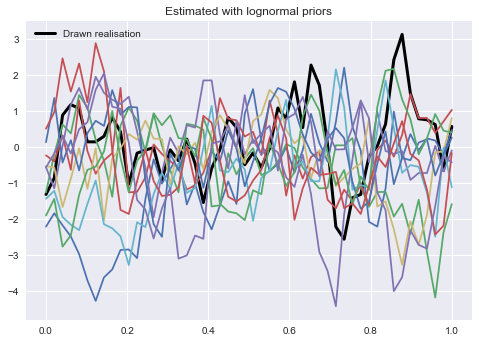

In [53]:
est_params = [est_U, est_N, est_LN]
titles = [
    "Estimated with uniform priors",
    "Estimated with normal priors",
    "Estimated with lognormal priors",
]
for k in range(3):
    params = est_params[k]
    plt.plot(t, OU_real, lw=3, c="k", label="Drawn realisation")
    for i in range(10):
        plt.plot(t, OU_process(t, [params]))
    plt.title(titles[k])
    plt.legend()
    plt.show()